In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from datetime import datetime

# importing csv files.
crimes_19 = pd.read_csv('input_data/Chicago_Crimes_2019.csv')
crimes_20 = pd.read_csv('input_data/Chicago_Crimes_2020.csv')
crimes_21 = pd.read_csv('input_data/Chicago_Crimes_2021.csv')

# merging crimes data for the last 3 years into a signle dataframe
crimes_data = pd.merge((pd.merge(crimes_19,crimes_20, how="outer")),crimes_21,how="outer")

print(len(crimes_data))


679438


In [2]:
# converting Date column in dataframe to date format and adding columns for month, year, day, time
crimes_data["Date"] = pd.to_datetime(crimes_data['Date'])
crimes_data["Day"] = crimes_data['Date'].dt.day_name()
crimes_data["Month Day"] =crimes_data['Date'].dt.day
crimes_data["Month"] = crimes_data['Date'].dt.month_name()
crimes_data["Year"] = crimes_data['Date'].dt.year
crimes_data["Time"] =crimes_data['Date'].dt.time
crimes_data["AM_PM"] = pd.to_datetime(crimes_data['Date']).dt.strftime("%p")
print(crimes_data.shape)
crimes_data.dropna(how = 'any', inplace = True)
print(crimes_data.shape)
crimes_data

(679438, 29)
(667920, 29)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Updated On,Latitude,Longitude,Location,Day,Month Day,Month,Year,Time,AM_PM
1,11554737,JC102447,2019-01-01 20:00:00,077XX S ABERDEEN ST,051A,ASSAULT,AGGRAVATED - HANDGUN,STREET,False,True,...,3/30/2020 15:48,41.753720,-87.651399,"(41.753720143, -87.65139884)",Tuesday,1,January,2019,20:00:00,PM
2,11552577,JC100040,2019-01-01 00:31:00,032XX W LAWRENCE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,RESTAURANT,False,False,...,1/10/2019 15:16,41.968444,-87.709342,"(41.968444497, -87.709341738)",Tuesday,1,January,2019,00:31:00,AM
3,11552587,JC100034,2019-01-01 00:05:00,006XX E 83RD PL,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,...,1/10/2019 15:16,41.742968,-87.608410,"(41.742968219, -87.6084099)",Tuesday,1,January,2019,00:05:00,AM
4,11552596,JC100045,2019-01-01 00:03:00,001XX W HURON ST,430,BATTERY,AGGRAVATED: OTHER DANG WEAPON,HOTEL/MOTEL,False,False,...,1/10/2019 15:16,41.894822,-87.632134,"(41.894821547, -87.632133928)",Tuesday,1,January,2019,00:03:00,AM
5,11552605,JC100030,2019-01-01 00:01:00,004XX N MONTICELLO AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,1/10/2019 15:16,41.889196,-87.717404,"(41.889196391, -87.717403722)",Tuesday,1,January,2019,00:01:00,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679290,12545582,JE450838,2021-11-19 19:53:00,021XX W LEXINGTON ST,2820,OTHER OFFENSE,TELEPHONE THREAT,GOVERNMENT BUILDING / PROPERTY,True,False,...,4/7/2022 16:45,41.872333,-87.679608,"(41.872332627, -87.679608149)",Friday,19,November,2021,19:53:00,PM
679291,12560829,JE469376,2021-12-07 16:49:00,057XX S MAY ST,430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,True,False,...,4/7/2022 16:45,41.790087,-87.653555,"(41.790086602, -87.653554734)",Tuesday,7,December,2021,16:49:00,PM
679317,12531163,JE433279,2021-11-04 00:59:00,034XX N OZANAM AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,False,...,4/7/2022 16:47,41.942213,-87.821580,"(41.942213367, -87.82158022)",Thursday,4,November,2021,00:59:00,AM
679404,12298015,JE148200,2021-02-21 19:16:00,037XX W ARMITAGE AVE,498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",RESIDENCE,True,True,...,4/13/2022 16:48,41.917234,-87.720926,"(41.917233894, -87.720925992)",Sunday,21,February,2021,19:16:00,PM


In [3]:
# list all the columns titles
crimes_data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'District_name', 'District_population', 'Ward',
       'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate',
       'Updated On', 'Latitude', 'Longitude', 'Location', 'Day', 'Month Day',
       'Month', 'Year', 'Time', 'AM_PM'],
      dtype='object')

# Total number of crimes and Arrests
1. Both total number of crimes and the total number of arrests in Chicago seem to be decreased for last three years.
2. The arrest percentage has also been decreased for last three years.
3. Most of the crimes did not result into arrests. In aggregate, only 17 % crimes resulted in Arrest.


In [4]:
# separate data for each year resulted into arrest 
arrest19_df  = pd.DataFrame(crimes_data[(crimes_data["Year"]==2019) & (crimes_data["Arrest"]== True)])
arrest20_df  = pd.DataFrame(crimes_data[(crimes_data["Year"]==2020) & (crimes_data["Arrest"]== True)])
arrest21_df  = pd.DataFrame(crimes_data[(crimes_data["Year"]==2021) & (crimes_data["Arrest"]== True)])

arrest19_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Updated On,Latitude,Longitude,Location,Day,Month Day,Month,Year,Time,AM_PM
5,11552605,JC100030,2019-01-01 00:01:00,004XX N MONTICELLO AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,1/10/2019 15:16,41.889196,-87.717404,"(41.889196391, -87.717403722)",Tuesday,1,January,2019,00:01:00,AM
8,11552614,JC100052,2019-01-01 00:28:00,056XX W DIVERSEY AVE,470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,BAR OR TAVERN,True,False,...,1/10/2019 15:16,41.931265,-87.766924,"(41.931265251, -87.766924444)",Tuesday,1,January,2019,00:28:00,AM
10,11552616,JC100027,2019-01-01 00:03:00,017XX N MAYFIELD AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENTIAL YARD (FRONT/BACK),True,False,...,1/10/2019 15:16,41.912052,-87.772807,"(41.912051569, -87.772807303)",Tuesday,1,January,2019,00:03:00,AM
11,11552617,JC100047,2019-01-01 00:29:00,011XX W NORTH SHORE AVE,460,BATTERY,SIMPLE,STREET,True,False,...,1/10/2019 15:16,42.003705,-87.659317,"(42.00370451, -87.659317195)",Tuesday,1,January,2019,00:29:00,AM
12,11552619,JC100048,2019-01-01 00:14:00,065XX S HOYNE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,1/10/2019 15:16,41.775037,-87.676227,"(41.775037102, -87.676227136)",Tuesday,1,January,2019,00:14:00,AM


In [5]:
# calculating total arrests in each year
total_arrest_19 = len(arrest19_df["ID"])
total_arrest_20 = len(arrest20_df["ID"])
total_arrest_21 = len(arrest21_df["ID"])
total_crimes_19 = len(crimes_data[crimes_data["Year"]==2019]["ID"])
total_crimes_20 = len(crimes_data[crimes_data["Year"]==2020]["ID"])
total_crimes_21 = len(crimes_data[crimes_data["Year"]==2021]["ID"])
print(f" 019 Arrest = {total_arrest_19}, 020 Arrest = {total_arrest_20}, 021 Arrest = {total_arrest_21}")
print(f" 019 crime = {total_crimes_19}, 020 crime = {total_crimes_20}, 021 crime = {total_crimes_21}")



 019 Arrest = 56035, 020 Arrest = 33706, 021 Arrest = 24674
 019 crime = 258143, 020 crime = 207427, 021 crime = 202350


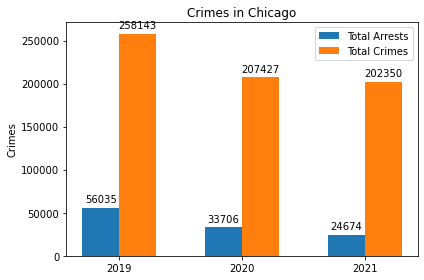

In [6]:
# Creating Bar plot for total crimes and arrests

Arrests = [total_arrest_19,total_arrest_20,total_arrest_21]
Total_crimes = [total_crimes_19,total_crimes_20,total_crimes_21]

labels = ["2019", "2020", "2021"]
x = np.arange(len(labels))

width = 0.3  #width of bar plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Arrests, width, label='Total Arrests')
rects2 = ax.bar(x + width/2, Total_crimes, width, label='Total Crimes')

#Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crimes')
ax.set_title('Crimes in Chicago')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig("Images/chicago_crime_arrest.png")
plt.show()


Conclusions: 
Both total number of crimes and the total number of arrests in Chicago seem to be decreased for last three years. 

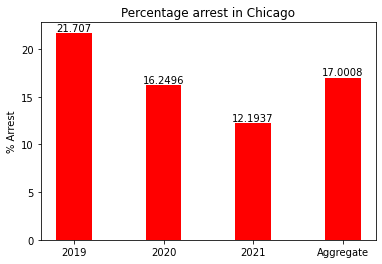

In [14]:
#Calculating Percentage arrest in each year
p_arrest2019 = 100*(total_arrest_19/total_crimes_19)
p_arrest2020 = 100*(total_arrest_20/total_crimes_20)
p_arrest2021 = 100*(total_arrest_21/total_crimes_21)

# calculating total percentage arrests in last three years
total_arrests = total_arrest_19 + total_arrest_20 + total_arrest_21  
total_crimes = total_crimes_19 + total_crimes_20 + total_crimes_20
p_total_arrest = 100*(total_arrests/total_crimes)

labels = [2019, 2020, 2021, "Aggregate"]
y = [p_arrest2019,p_arrest2020,p_arrest2021, p_total_arrest]

x = np.arange(len(labels))
fig, ax = plt.subplots()
width = 0.3
plot1 = ax.bar(x,y, width = 0.4, color = 'r')
ax.set_ylabel("% Arrest")
ax.set_title('Percentage arrest in Chicago')
ax.set_xticks(x, labels)
ax.bar_label(plot1)
plt.savefig("Images/Percentage_arrests.png")

In [8]:
# Domestic vs non domestic

domestic_crimes_no = len(crimes_data[crimes_data["Domestic"] == True]["ID"])
total_crimes_no = len(crimes_data["ID"])
non_domestic = total_crimes_no - domestic_crimes_no


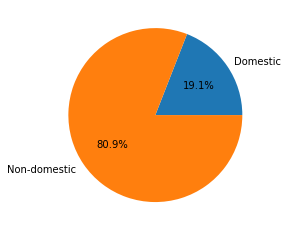

In [9]:
#Pi plot to show share of domestic crimes to total crimes

labels = ["Domestic", "Non-domestic"]
sizes = [domestic_crimes_no, non_domestic ]

fig, ax = plt.subplots()
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
plt.savefig("Images/Pie_Domestic_vs_nonDomestic.png")

In [10]:
#Grouping data by crime type
crime_type = crimes_data.groupby("Primary Type")["ID"].count()

crime_type


Primary Type
ARSON                                  1485
ASSAULT                               59061
BATTERY                              131204
BURGLARY                              24951
CONCEALED CARRY LICENSE VIOLATION       534
CRIM SEXUAL ASSAULT                     995
CRIMINAL DAMAGE                       76153
CRIMINAL SEXUAL ASSAULT                3151
CRIMINAL TRESPASS                     14333
DECEPTIVE PRACTICE                    48198
GAMBLING                                180
HOMICIDE                               2110
HUMAN TRAFFICKING                        30
INTERFERENCE WITH PUBLIC OFFICER       2513
INTIMIDATION                            441
KIDNAPPING                              377
LIQUOR LAW VIOLATION                    555
MOTOR VEHICLE THEFT                   29354
NARCOTICS                             26354
NON-CRIMINAL                              8
OBSCENITY                               156
OFFENSE INVOLVING CHILDREN             5949
OTHER NARCOTIC VIOL